In [8]:
%load_ext autoreload

In [9]:
%autoreload 2

In [10]:
import sys
import dawis as d
import glob as glob
import os
import numpy as np
import pyregion as pyr
import random
import gc
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import *
from scipy.stats import kurtosis
from power_ratio import *
from datetime import datetime
from photutils.segmentation import SourceCatalog, detect_sources
import make_results_ERO_noray
import tracemalloc
import matplotlib
print(plt.get_backend())
matplotlib.use('Agg')


agg


In [4]:
help(make_results_ERO_noray.synthesis_bcgwavsizesep_with_masks)

Help on function synthesis_bcgwavsizesep_with_masks in module make_results_ERO_noray:

synthesis_bcgwavsizesep_with_masks(nfp, lvl_sep, lvl_sep_max, lvl_sep_bcg, size_sep, size_sep_pix, xs, ys, n_levels, mscstar, mscell, mscbcg, mscsedl, msat, R, rc_pix, N_err, per_err, flux_lim, kurt_filt=True, plot_vignet=False, write_fits=True, measure_PR=False, plot_boot=False)
    Wavelet Separation + Spatial filtering.
    ICL --> Atoms with z > lvl_sep, with maximum coordinates within ellipse mask 'mscell' and with size > size_sep_pix.
    Galaxies --> Satellites + BCG, so a bit complicated:
        - Atoms not classified as ICL but with maximum coordinates within ellipse mask 'mscbcg'
        - Atoms within radius 'rc' of a member galaxy position
        - In case lvl_sep > 5 (arbitrary...), atoms with z > 5 and within 'mscell' are BCG
    Unclassified --> rest of atoms



In [13]:
# Paths, lists & variables
path_data = '/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/final'
path_scripts = '/home/aellien/Euclid_ERO/Euclid_ERO_scripts'
path_wavelets = '/home/aellien/Euclid_ERO/wavelets/out16/'
path_plots = '/home/aellien/Euclid_ERO/plots'
path_analysis = '/home/aellien/Euclid_ERO/analysis/'

In [14]:
# Input files
#nfl = [ 'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl6.bkg_sub.input.fits','Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl6.bkg_sub.input.fits', 
#       'Euclid-NISP-J-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl6.bkg_sub.input.fits']
nfl = [ 'Euclid-NISP-J-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl6.bkg_sub.input.fits']       

# spatial scales related
pix_scale = 0.3 # "/pix
physcale = 3.68 # kpc/"
size_sep = 100 # size separation [kpc]
size_sep_pix = size_sep / physcale / pix_scale # pixels
R_kpc = 1000 # radius in which quantities are measured [kpc]
R_pix = R_kpc / physcale / pix_scale # pixels
R = R_pix
rc = 10 # kpc, distance to center to be classified as gal
rc_pix = rc / physcale / pix_scale # pixels
            
# wavelet scales related
lvl_sep = 5 # wavelet scale separation
lvl_sep_bcg = 4
lvl_sep_max = 1000
n_levels = 10

# photometry
mu_lim = 35
ZP_AB = 30
flux_lim = 10**( (ZP_AB - mu_lim) / 2.5 )

# bootstrap
N_err = 100
per_err = 0.05

# misc
kurt_filt = True
plot_vignet = False
write_fits = True
measure_PR = True
write_dataframe = True
plot_boot = True

# Masks
mscell = fits.getdata(os.path.join(path_analysis,'mscell.fits'))
mscbcg = fits.getdata(os.path.join(path_analysis,'mscbcg.fits'))
mscstar = fits.getdata(os.path.join(path_analysis,'mscstar.fits'))
msat = fits.getdata(os.path.join(path_analysis,'msat.fits'))
mscsedl = []

In [ ]:
# Iterate over dictionary list
results = []
for nf in nfl:
    
    # Read image data from dic
    filt = nf.split('-')[2]
    print(nf)
    
    #Read image file
    nfp = os.path.join( path_wavelets, nf[:-4] )
    oim_file = os.path.join( path_data, nf )
    hdu = fits.open(oim_file)
    oim, header = hdu[0].data, hdu[0].header
    xs, ys = oim.shape

    tracemalloc.start()
    # path, list & variables
    icl = np.zeros( (xs, ys) )
    icl_dei = np.zeros( (xs, ys) )
    gal = np.zeros( (xs, ys) )
    gal_dei = np.zeros( (xs, ys) )
    im_art = np.zeros( (xs, ys) )
    im_unclass = np.zeros( (xs, ys) )
    im_unclass_dei = np.zeros( (xs, ys) )
    recim = np.zeros( (xs, ys) )

    tot_icl_al = []
    tot_gal_al = []
    #tot_noticl_al = []
    icl_boot_al = []

    #%
    at_test = []
    #%

    xc = xs / 2.
    yc = ys / 2.

    ######################################## MEMORY v
    opath = nfp + '*ol.it*.hdf5'
    opathl = glob.glob(opath)
    opathl.sort()
    memory = []
    marea = []
    for i, op in enumerate(opathl):
        
        print('Iteration %d' %(i))#, end ='\r')
        #snapshot = tracemalloc.take_snapshot()
        #top_stats = snapshot.statistics('lineno')
        #print(top_stats[0])
        #memory.append(top_stats[0].size/1e9)
        
        
        #ol = d.store_objects.read_ol_from_hdf5(op)
        #itl = d.store_objects.read_itl_from_hdf5(itlp)
        with h5py.File(op, "r") as f1:
            gc.collect()
            icl_al = []
            gal_al = []
            noticl_al = []
            unclass_al = []
            areal = []
            for o in f1.keys():

                x_min, y_min, x_max, y_max = np.copy(f1[o]['bbox'][()])
                image = np.copy(f1[o]['image'][()])
                det_err_image = np.copy(f1[o]['det_err_image'][()])
                lvlo = np.copy(f1[o]['level'][()])
                ######################################## MEMORY ^
            
                sx = x_max - x_min
                sy = y_max - y_min
                areal.append(sx*sy)
                m = detect_sources(image, threshold = 0., npixels=1)
                c = SourceCatalog(image, m)
                xco = int(c.centroid_quad[0][1] + x_min)
                yco = int(c.centroid_quad[0][0] + y_min)
            
                if kurt_filt == True:
                    k = kurtosis(image.flatten(), fisher=True)
                    if k < 0:
                        im_art[ x_min : x_max, y_min : y_max ] += image
                        gc.collect()
                        continue
                
                recim[ x_min : x_max, y_min : y_max ] += image

                # Remove background, and add it to bootstrap if center is within ICL ellipse
                if lvlo >= lvl_sep_max:
                    if mscell[xco, yco] == 1:
                        icl_boot_al.append([image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo])
                    continue
        
                # Only atoms within analysis radius
                dR = np.sqrt( (xc - xco)**2 + (yc - yco)**2 )
                if dR > R:
                    continue
    
                # ICL + BCG
                if (mscstar[xco, yco] != 1) & (mscell[xco, yco] == 1):
    
                    '''# BCG
                    xbcg, ybcg = [ xs, ys ] # pix long, ds9 convention
                    if mscbcg[xco, yco] == 1:
    
                        dr = np.sqrt( (xbcg - xco)**2 + (ybcg - yco)**2 )
                        if (o.level <= 3) & (dr < rc_pix):
    
                            icl[ x_min : x_max, y_min : y_max ] += o.image
                            icl_al.append([o, xco, yco])
    
                        elif o.level >= 4:
                            icl[ x_min : x_max, y_min : y_max ] += o.image
                            icl_al.append([o, xco, yco])'''
                            
                    # BCG
                    if mscbcg[xco, yco] == 1:
                        icl[ x_min : x_max, y_min : y_max ] += image
                        icl_dei[ x_min : x_max, y_min : y_max ] += det_err_image
                        icl_al.append([image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo])
                        tot_icl_al.append([image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo])
                        continue
    
                    # ICL
                    if (lvlo >= lvl_sep) & (sx >= size_sep_pix) & (sy >= size_sep_pix):

                        #%%%%% Je laisse au cas où %%%%% v
                        coo_spur_halo =  [ [2142, 2216], [1890, 2270] ] # pix long, ds9 convention
                        flag = False
                        for ygal, xgal in coo_spur_halo:

                            dr = np.sqrt( (xgal - xco)**2 + (ygal - yco)**2 )
                            if (dr <= 100) & (4 < lvlo < 7 ):
                                flag = True
                        #%%%%%%% ^^^^^^^^^^^^^^^^^^^^^^^^^^
                            
                        if flag == False:
                            icl[ x_min : x_max, y_min : y_max ] += image
                            icl_dei[ x_min : x_max, y_min : y_max ] += det_err_image
                            icl_al.append([image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo])
                            tot_icl_al.append([image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo])
                            at_test.append([xco, yco])
                            continue
                        
                        noticl_al.append([image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo])
                            
                    else:
                        noticl_al.append([image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo])
                else:
                    noticl_al.append([image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo])
                    
            # Galaxies
            for j, (image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo) in enumerate(noticl_al):
                
                # Satellites
                if (mscstar[xco, yco] != 1) & (lvlo < lvl_sep) & (msat[xco, yco] == 1):

                    gal[ x_min : x_max, y_min : y_max ] += image
                    gal_dei[ x_min : x_max, y_min : y_max ] += det_err_image
                    gal_al.append([image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo])
                    tot_gal_al.append([image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo])

                    # add 'tendencious' galaxy atoms to list for bootstrap
                    if ( lvlo == (lvl_sep - 1)) & (mscell[xco, yco] == 1):
                        icl_boot_al.append([image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo]) 
                        
                # If not identified as galaxies --> test if BCG again
                else:
                    unclass_al.append([image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo])

            # Test for unclassified atoms --> sometimes extended BCG halo is missed because
            # of the nature of wavsep scheme.
            for j, (image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo) in enumerate(unclass_al):
                
                # Case in which it is possible that it is BCG halo?
                if (lvl_sep > lvl_sep_bcg) & (lvlo >= lvl_sep_bcg) & (np.sqrt( (xc - xco)**2 + (yc - yco)**2 ) < 100) :
                    icl[ x_min : x_max, y_min : y_max ] += image
                    icl_dei[ x_min : x_max, y_min : y_max ] += det_err_image
                    icl_al.append([image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo])
    
                #If not --> unclassified 
                else:
                    im_unclass[ x_min : x_max, y_min : y_max ] += image
                    im_unclass_dei[ x_min : x_max, y_min : y_max ] += det_err_image
                    
                    #  add tendencious atoms to list for bootstrap (arbitrary conditions)
                    if ( lvlo == (lvl_sep - 1)) & (mscell[xco, yco] == 1):
                        icl_boot_al.append([image, det_err_image, x_min, y_min, x_max, y_max, xco, yco, lvlo])
                        
            marea.append(np.mean(areal))
            print(len(tot_icl_al), len(tot_gal_al), len(icl_boot_al))

            
    # clear some memory
    gc.collect()
    icl_al.clear()
    gal_al.clear()
    noticl_al.clear()
    unclass_al.clear()
    
    if write_fits == True:

        # BCG SIZE SEP
        print('\nWS + SF + SS -- ICL+BCG -- LVL_SEP = %d -- write fits as %s*'%(lvl_sep, nfp))
        hdu = fits.PrimaryHDU()
        hdu_icl = fits.ImageHDU(icl, name = 'ICL+BCG', header = header)
        hdu_gal = fits.ImageHDU(gal, name = 'SATELLITES', header = header)
        tot = gal + icl
        hdu_tot = fits.ImageHDU(tot, name = 'ICL+BCG+SATELLITES', header = header)
        hdu_icl_dei = fits.ImageHDU(icl_dei, name = 'ICL+BCG DET. ERR.', header = header)
        hdu_gal_dei = fits.ImageHDU(gal_dei, name = 'SAT DET. ERR.', header = header)
        tot_dei = icl_dei + gal_dei
        hdu_tot_dei = fits.ImageHDU(tot_dei, name = 'ICL+BCG+SAT DET. ERR.', header = header)
        hdu_unclass = fits.ImageHDU(im_unclass, name = 'UNCLASSIFIED', header = header)
        hdu_unclass_dei = fits.ImageHDU(im_unclass, name = 'UNCLASSIFIED DET. ERR.', header = header)
        hdul = fits.HDUList([ hdu, hdu_icl, hdu_gal, hdu_tot, hdu_unclass, hdu_icl_dei, hdu_gal_dei, hdu_tot_dei, hdu_unclass_dei ])
        hdul.writeto( nfp + 'synth.bcgwavsizesepmask_%03d_%03d.fits'%(lvl_sep, size_sep), overwrite = True )
        
        # FULL FIELD
        hdu = fits.PrimaryHDU()
        hdu_oim = fits.ImageHDU(oim, name = 'ORIGINAL', header = header)
        hdu_recim = fits.ImageHDU(recim, name = 'REC.', header = header)
        hdu_res = fits.ImageHDU(oim - recim, name = 'RESIDUALS', header = header)
        hdul = fits.HDUList([ hdu, hdu_oim, hdu_recim, hdu_res ])
        hdul.writeto( nfp + 'synth.full_field.fits', overwrite = True )
        

    if measure_PR == True:
        print('start bootstrap')
        start = datetime.now()
        # Measure Fractions and uncertainties
        F_ICL_m, F_ICL_low, F_ICL_up, FICL_det_err, low_FICL_det_err, up_FICL_det_err, out_sed_icl =  make_results_ERO_noray.selection_error(tot_icl_al, icl_boot_al, M = N_err, percent = per_err, xs = xs, ys = ys, flux_lim = flux_lim, mscsedl = mscsedl, write_plots = plot_boot, nfp = nfp, name = 'icl')
        F_gal_m, F_gal_low, F_gal_up, Fgal_det_err, low_Fgal_det_err, up_Fgal_det_err, out_sed_gal =  make_results_ERO_noray.selection_error(tot_gal_al, icl_boot_al, M = N_err, percent = per_err, xs = xs, ys = ys, flux_lim = flux_lim, mscsedl = mscsedl)
        f_ICL_m = F_ICL_m / (F_ICL_m + F_gal_m)
        f_ICL_low = F_ICL_low / (F_ICL_low + F_gal_up)
        f_ICL_up = F_ICL_up / (F_ICL_up + F_gal_low)
        print(datetime.now() - start)
        
        print('\nWS + SF -- ICL+BCG --  z = %d'%lvl_sep)
        print('N = %4d   F_ICL = %f Mjy/sr  err_low = %f Mjy/sr  err_up = %f Mjy/sr'%(len(tot_icl_al), F_ICL_m, F_ICL_low, F_ICL_up))
        print('N = %4d   F_gal = %f Mjy/sr  err_low = %f Mjy/sr  err_up = %f Mjy/sr'%(len(tot_gal_al), F_gal_m, F_gal_low, F_gal_up))
        print('Det. error: deICL = %f ADU  deICL_low = %f  deICLup = %f ADU'%(FICL_det_err, low_FICL_det_err, up_FICL_det_err))
        print('f_ICL = %1.3f    f_ICL_low = %1.3f   f_ICL_up = %1.3f'%(f_ICL_m, f_ICL_low, f_ICL_up))
        
        # Measure Power ratio
        #results_PR = make_results_ERO_noray.PR_with_selection_error(atom_in_list = tot_icl_al, atom_out_list = tot_unclass_al+tot_gal_al, M = N_err, percent = per_err, R = R, xs = xs, ys = ys)
        PR_1_m, PR_1_up, PR_1_low = np.nan, np.nan, np.nan#results_PR[0]
        PR_2_m, PR_2_up, PR_2_low = np.nan, np.nan, np.nan#results_PR[1]
        PR_3_m, PR_3_up, PR_3_low = np.nan, np.nan, np.nan#results_PR[2]
        PR_4_m, PR_4_up, PR_4_low = np.nan, np.nan, np.nan#results_PR[3]
        
        print('PR_1_m = %1.2e    PR_1_low = %1.2e    PR_1_up = %1.2e'%(PR_1_m, PR_1_low, PR_1_up))
        print('PR_2_m = %1.2e    PR_2_low = %1.2e    PR_2_up = %1.2e'%(PR_2_m, PR_2_low, PR_2_up))
        print('PR_3_m = %1.2e    PR_3_low = %1.2e    PR_3_up = %1.2e'%(PR_3_m, PR_3_low, PR_3_up))
        print('PR_4_m = %1.2e    PR_4_low = %1.2e    PR_4_up = %1.2e'%(PR_4_m, PR_4_low, PR_4_up))


    if write_dataframe == True:
        results.append(pd.DataFrame( [[ nf, filt, 'WS+BCGSS+SF', R_kpc, R_pix, lvl_sep, size_sep, F_ICL_m, F_ICL_low, F_ICL_up, F_gal_m, F_gal_low, F_gal_up, f_ICL_m, f_ICL_low, f_ICL_up, PR_1_m, PR_1_up, PR_1_low, PR_2_m, PR_2_up, PR_2_low, PR_3_m, PR_3_up, PR_3_low, PR_4_m, PR_4_up, PR_4_low ]], \
                        columns = [ 'nf', 'filter', 'Atom selection scheme', 'R_kpc', 'R_pix', 'lvl_sep', 'size_sep','F_ICL_m', 'F_ICL_low', 'F_ICL_up', 'F_gal_m', 'F_gal_low', 'F_gal_up', 'f_ICL_m', 'f_ICL_low', 'f_ICL_up', 'PR_1_m', 'PR_1_up', 'PR_1_low', 'PR_2_m', 'PR_2_up', 'PR_2_low', 'PR_3_m', 'PR_3_up', 'PR_3_low', 'PR_4_m', 'PR_4_up', 'PR_4_low'  ]))
    
    snapshot = tracemalloc.take_snapshot()
    top_stats = snapshot.statistics('lineno')
    for stat in top_stats[:20]:
        print(stat)

if write_dataframe == True:
    output_df = results[0]
    for df in results[1:]:
        output_df = pd.concat( [output_df, df], ignore_index = True)


Euclid-NISP-J-ERO-Abell2390-LSB.DR3.crop.synth.cirrus_lvl6.bkg_sub.input.fits
Iteration 0
0 0 0
Iteration 1
1 99 0
Iteration 2
3 129 0
Iteration 3
3 139 0
Iteration 4
4 204 0
Iteration 5
5 248 0
Iteration 6
5 280 0
Iteration 7
5 284 0
Iteration 8
6 308 0
Iteration 9
6 309 0
Iteration 10
7 345 0
Iteration 11
7 347 0
Iteration 12
7 349 0
Iteration 13
8 438 0
Iteration 14
8 439 0
Iteration 15
8 446 0
Iteration 16
10 464 0
Iteration 17
12 550 0
Iteration 18
12 550 0
Iteration 19
13 555 0
Iteration 20
15 626 0
Iteration 21
16 632 0
Iteration 22
16 632 0
Iteration 23
16 632 0
Iteration 24
17 675 0
Iteration 25
17 685 0
Iteration 26
17 727 0
Iteration 27
17 729 0
Iteration 28
17 741 0
Iteration 29
17 745 0
Iteration 30
17 748 0
Iteration 31
17 751 0
Iteration 32
17 756 0
Iteration 33
18 787 40
Iteration 34
19 825 89
Iteration 35
20 865 141
Iteration 36
21 908 196
Iteration 37
22 956 259
Iteration 38
23 1011 332
Iteration 39
23 1011 332
Iteration 40
24 1068 412
Iteration 41
25 1126 502
Iterati

In [21]:
output_df[['filter', 'Atom selection scheme', 'lvl_sep',
       'size_sep', 'f_ICL_m', 'f_ICL_low', 'f_ICL_up', 'F_ICL_m', 'F_ICL_low', 'F_ICL_up', 'F_gal_m', 'F_gal_low',
       'F_gal_up']]
output_df[['filter', 'Atom selection scheme', 'lvl_sep',
       'size_sep', 'f_ICL_m', 'f_ICL_low', 'f_ICL_up', 'F_ICL_m', 'F_ICL_low', 'F_ICL_up', 'F_gal_m', 'F_gal_low',
       'F_gal_up']].to_csv('/home/aellien/Euclid_ERO/analysis/A2390_ERO_ICL_fractions_cirrus_cleaned_26082924.csv')

In [24]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

print(top_stats[0])

                           icl: 98.9 MiB
                       icl_dei: 98.9 MiB
                           gal: 98.9 MiB
                       gal_dei: 98.9 MiB
                        im_art: 98.9 MiB
                    im_unclass: 98.9 MiB
                im_unclass_dei: 98.9 MiB
                           tot: 98.9 MiB
                       tot_dei: 98.9 MiB
                         image:  4.0 MiB
/home/aellien/anaconda3/envs/jwst-env/lib/python3.11/site-packages/numpy/lib/function_base.py:962: size=2663 MiB, count=9170, average=297 KiB


In [16]:
plt.figure()
plt.plot(memory, label = 'memory / Gb')
plt.plot(marea, label = 'area')
plt.legend()
plt.yscale('log')
plt.show()

/tmp/ipykernel_250853/766522733.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


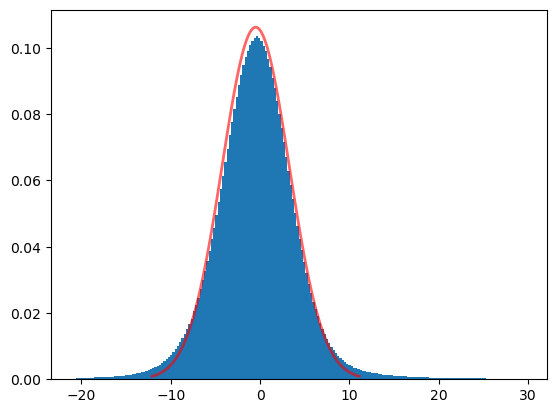

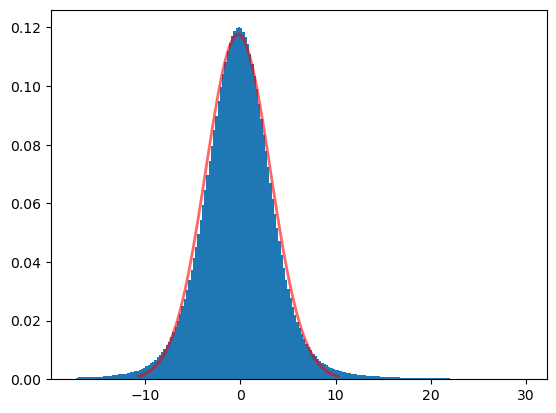

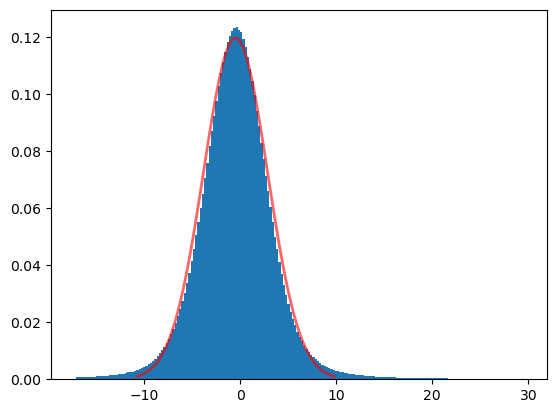

In [98]:
# Masked models + tests residuals histograms
from scipy.stats import norm
import matplotlib.mlab as mlab

m_all_but_bcg = fits.getdata(os.path.join(path_analysis, 'Abell_2390_NISP_mask_all_but_bcg_full_img_H_crop.fits'), 1)
m_all_but_bcg[m_all_but_bcg != 1] = 0
m_all_but_sat = fits.getdata(os.path.join(path_analysis, 'Abell_2390_NISP_mask_all_but_clmembers_full_img_H_crop.fits'), 1)
m_all_but_sat[m_all_but_sat != 1] = 0
nfl = [ 'Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.crop.fits','Euclid-NISP-J-ERO-Abell2390-LSB.DR3.crop.fits', 
       'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.crop.fits']
for nf in nfl:
    #nfp = os.path.join(path_wavelets, nf[:-4]+'synth.full_field.fits')
    #hdu = fits.open(nfp)
    #rim = hdu[2].data
    #res = hdu[3].data
    #res = res[(res<(np.median(res)+10))&(res > (np.median(res)-10))]
    #rim[~m_all_but_bcg.astype(bool)] = 0
    #hduo = fits.PrimaryHDU(rim)
    #hduo.writeto(os.path.join(path_wavelets, nf[:-4] + 'synth.full_field.masked.fits'), overwrite = True)
    
    nfp = os.path.join(path_wavelets, nf[:-4]+'residuals.fits')
    res = fits.getdata(nfp)
    res = res[(res<(np.median(res)+30))&(res > (np.median(res)-30))]
    
    icl = fits.getdata(os.path.join(path_wavelets, nf[:-4]+'synth.bcgwavsizesepmask_005_100.fits'), 3)
    icl[~m_all_but_bcg.astype(bool)] = 0
    hduo = fits.PrimaryHDU(icl)
    hduo.writeto(os.path.join(path_wavelets, nf[:-4] + 'synth.bcgwavsizesepmask_005_100.masked.fits'), overwrite = True)

    (mu, sigma) = norm.fit(res[(res<(np.median(res)+10))&(res > (np.median(res)-10))])
    x = np.linspace(norm.ppf(0.001, mu, sigma), norm.ppf(0.999, mu, sigma), 100)
    plt.figure()
    plt.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=2, alpha=0.6, label='norm pdf')
    n, bins, patches = plt.hist(res, density = True, bins = 200)
    
    plt.show()

In [10]:
nfl = [ 'Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.crop.fits','Euclid-NISP-J-ERO-Abell2390-LSB.DR3.crop.fits', 
       'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.crop.fits']
matplotlib.use('TkAgg')

for nf in nfl:
    nfp = os.path.join(path_wavelets, nf[:-4]+'synth.full_field.fits')
    hdu = fits.open(nfp)
    res = hdu[3].data

    plt.close('all')
    plt.figure()
    plt.imshow(100 * (res - res.mean())/res.mean(), origin = 'lower', vmax = 5, vmin = -5 )
    plt.suptitle(r'%s band | mean(res) = %3.2f ADU | Median = %1.1f percents'%(nf.split('-')[2], res.mean(), np.median(100 * (res - res.mean())/res.mean())))
    plt.colorbar(label = '(mean(res) - res)/mean(res)')
    print(np.median(100 * (res - res.mean())/res.mean()))
plt.show()

3.404334290909774
2.54247788285961
2.1243587797194707


In [12]:
2**11

2048

In [28]:
# Abell_2390_NISP_mask_all_but_clmembers_1mpc_JHY.fits
# Abell_2390_NISP_mask_all_but_bcg_1mpc_JHY.fits
from skimage.morphology import binary_dilation, binary_erosion
hdu1 = fits.open('/home/aellien/Euclid_ERO/analysis/Abell_2390_NISP_mask_all_but_clmembers_1mpc_JHY.fits')
hdu2 = fits.open('/home/aellien/Euclid_ERO/analysis/Abell_2390_NISP_mask_all_but_bcg_1mpc_JHY.fits')
m1, header = hdu1[0].data, hdu1[0].header
m2 = hdu2[0].data
#m2 = binary_dilation(m2)
#m1 = binary_erosion(m1)
m3 = m1 + m2
#m3[m3 != 1] = 0

hduo = fits.PrimaryHDU(m3, header = header)
hduo.writeto('/home/aellien/Euclid_ERO/analysis/mast_new.fits', overwrite = True)

In [33]:
r = pyr.open('/home/aellien/Euclid_ERO/analysis/icl_mock_circle_2arcmin_vignet.reg')
hduv = fits.open('~/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/vignets/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.mock.revrot_vignet_2.fits')
m = r.get_mask(hdu = hduv[0])
hduo = fits.PrimaryHDU(m.astype(int), header = hduv[0].header)
hduo.writeto('/home/aellien/Euclid_ERO/analysis/icl_mock_circle_2arcmin_vignet.fits', overwrite = True)